In [152]:
from Levenshtein import distance, ratio
from sklearn.metrics import accuracy_score, f1_score, pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
import json
import re 
import html
import aiohttp
import asyncio
import nest_asyncio
import time
import os
import pickle
from rdflib import Graph
from SPARQLWrapper import SPARQLWrapper, JSON, N3
from aiosparql.client import SPARQLClient
from treelib import Node, Tree

## ProcessTableAsync
Function ProcessTableAsync takes as inut a filename and outputs the array [labels, baselineUri, trueEntitiesUri, allCandidates, filename]:

**labels** ist an array of the labels that were found in the key column: [label1, label2, ...]

**baselineUri** is an array of the DBPedia URI's that where matched the basline e.g. pick the label with the lowest levenshtein distance to the table cell entry: [Uri1, Uri2, ...]

**trueEntitiesUri** is an array of the TRUE entities meant by the labels [TrueUri1, TrueUri2, ...]

**allCandidates** is an array of all candidates batches for each label [[candidateLabel1, candidateUri1], [candidateLabel2, candidateUri2], ... ]

**filename** is the filename of the table

In [501]:
nest_asyncio.apply()

def processTableAsync(filename, number_of_candidates = 5):
    print("handling", filename)
    
    #load all relevant data in memory
    table = pd.read_csv('data/Tables/Goldstandard/embeddingsCorrespondence/table/'+filename)
    attri = pd.read_csv('data/Tables/Goldstandard/embeddingsCorrespondence/attributes/'+filename, header=None)
    entities = pd.read_csv('data/Tables/Goldstandard/embeddingsCorrespondence/entities/'+filename, header=None)
    
    trueEntitiesUri = [str(ent) for ent in entities.sort_values(2)[0]]
    keyAttribute = attri.loc[attri[2] == True,1].values[0]
    
    #sometimes the key Attribute is NaN as the label of the Column in the table in "Null"
    if(keyAttribute != keyAttribute):
        keyAttribute = "NULL"
        
    labels = []
    for label in table[keyAttribute]:
        #preprocessing the labels
        label = html.unescape(re.sub(r"[\s]+", " ", re.sub(r"[\(\[].*?[\)\]]", "", label))).strip()
        labels.append(label)
        
    #asyncronously get all the entity candidates
    dBPediaLookupResponses = asyncio.run(get_all_dbPedia_lookup_Responses_for_a_table(labels, number_of_candidates))
    dBPediaLookupResponses = np.array(dBPediaLookupResponses)
    
    #Sorting the responses because of asyncronousity we can not asure the same order as before
    sortedLookupResponses = []
    for label in labels:
        response = dBPediaLookupResponses[np.where(dBPediaLookupResponses == label)[0][0]][0]
        sortedLookupResponses.append(response)
    
    allCandidates = []
    baselineUri = []
    for res, label in zip(sortedLookupResponses, labels):
        dbPediaLookupResp = json.loads(res)
        candidateLabelsUri = []
        for jsonCandidate in dbPediaLookupResp["docs"]:
            try:
                #sometimes the entities didn't have the rdfs:label property... 
                jsonCandidate["label"]
            except KeyError:
                print("in lookup for '{}' there was something wrong (no label)".format(label))
                continue
            candidateLabelsUri.append([jsonCandidate["label"][0], jsonCandidate["resource"][0]])
        
        #wenn nichts gefunden wurde im Lookup füge dummy candidate ein
        if len(candidateLabelsUri) == 0:
            candidateLabelsUri = [["nichts_gefunden_im_Lookup", "https://www.dbpedia.org/"]]
            
        allCandidates.append(candidateLabelsUri)
        
        #below baseline results are gather; the candidate with lowest Levenstein distance
        try:
            maxSimilarityEntity = min(candidateLabelsUri, key=lambda k: distance(k[0].lower(), label.lower()))
            baselineUri.append(maxSimilarityEntity[1])
        except ValueError:
            print(label, "nichts_gefunden_in_DBlookup")
            baselineUri.append("https://www.dbpedia.org/")
            continue

    return [labels, baselineUri, trueEntitiesUri, allCandidates, filename]


#Functions to gather the DBpedia lookup results asyncronously
async def get_dbPedia_lookup(session, label, number_of_candidates):
    try:
        async with session.get('https://lookup.dbpedia.org/api/search?format=JSON_RAW&maxResults='+str(number_of_candidates)+'&query='+label) as res:
            return [await res.text(), label]
    except aiohttp.ClientConnectionError:
        print("try again")
        async with session.get('https://lookup.dbpedia.org/api/search?format=JSON_RAW&maxResults='+str(number_of_candidates)+'&query='+label) as res:
            return [await res.text(), label]
        
async def get_all_dbPedia_lookup_Responses_for_a_table(labels, number_of_candidates):
    tasks = []
    async with aiohttp.ClientSession(connector=aiohttp.TCPConnector(limit_per_host=18)) as session:
        for label in labels:
            dbPediaLookUp = asyncio.create_task(get_dbPedia_lookup(session, label, number_of_candidates))
            tasks.append(dbPediaLookUp)
        dbPediaLookUps = await asyncio.gather(*tasks)
    return dbPediaLookUps

C:\ProgramData\Anaconda3\envs\py39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Below I collect the Baseline results by letting the function above run on all the wanted tables

In [502]:
start = time.time()
for number_of_candidates in range(2,7):
    resultBaselineCEAGS = []
    for filename in os.listdir('data/Tables/Goldstandard/embeddingsCorrespondence/table/'):
        resultBaselineCEAGS.append(processTableAsync(filename, number_of_candidates))

    pickle.dump(resultBaselineCEAGS, open( "baseline_cea_T2De_"+str(number_of_candidates)+"_candidates", "wb"))
    print(time.time(), time.time() - start, "number_of_candidates: "+str(number_of_candidates))
    start = time.time()

handling 1146722_1_7558140036342906956.csv
handling 11688006_0_8123036130090004213.csv
handling 11833461_1_3811022039809817402.csv
handling 12125836_0_1134348206297032434.csv
handling 12193237_0_8699643798888088574.csv
handling 12271141_0_8517913935669973086.csv
handling 13395751_3_369722706637560735.csv
handling 14067031_0_559833072073397908.csv
handling 14380604_4_3329235705746762392.csv
handling 1614988_0_8789868670151796042.csv
handling 16767252_0_2409448375013995751.csv
handling 19073331_0_2742992342272078110.csv
handling 20135078_0_7570343137119682530.csv
handling 21329809_0_5526008408364682899.csv
handling 21362676_0_6854186738074119688.csv
handling 21585935_0_294037497010176843.csv
handling 21801207_0_8144839668470123042.csv
handling 24036779_0_5608105867560183058.csv
handling 24142265_0_4577466141408796359.csv
handling 24417511_0_3058323105166963431.csv
handling 24850757_0_5978004733768297283.csv
handling 25404227_0_2240631045609013057.csv
handling 25933880_0_40585549855744166

handling 62564020_0_3836030043284699244.csv
handling 64499281_8_7181683886563136802.csv
handling 66009064_0_9148652238372261251.csv
handling 67865873_0_8259587610208037357.csv
handling 68779923_0_3859283110041832023.csv
handling 68779923_1_3240042497463101224.csv
handling 68779923_2_1000046510804975562.csv
handling 68779923_4_1832350971585698643.csv
handling 68779923_5_2067037721454758189.csv
handling 69881946_0_1105130426898457358.csv
handling 70404164_0_5498195978476333642.csv
handling 70883081_0_5357790421435123524.csv
handling 71137051_0_8039724067857124984.csv
handling 71840765_0_6664391841933033844.csv
handling 72017594_0_7055198579167316152.csv
handling 73242003_5_4847571983313033360.csv
handling 74491133_0_7177831100884797849.csv
handling 74685423_0_8061289760697103949.csv
handling 74718406_0_3914457597478137388.csv
handling 75367212_2_2745466355267233390.csv
handling 76373906_0_6904594838446307331.csv
handling 77632062_0_2292892375652659825.csv
handling 77694908_0_608329134099

handling 29414811_6_8221428333921653560.csv
handling 29886325_0_1448173912684571475.csv
handling 32051842_5_1757891723986774036.csv
handling 33167985_0_5220049369716352813.csv
handling 34041816_1_4749054164534706977.csv
handling 35188621_0_6058553107571275232.csv
in lookup for 'throne of blood' there was something wrong (no label)
handling 37541068_1_1156932518917623732.csv
handling 37856682_0_6818907050314633217.csv
handling 38428277_0_1311643810102462607.csv
handling 38732532_0_1420803645394505878.csv
handling 39107734_2_2329160387535788734.csv
handling 3917335_0_7791699395300625164.csv
handling 39173938_0_7916056990138658530.csv
handling 39759273_0_1427898308030295194.csv
handling 40534006_0_4617468856744635526.csv
handling 41336118_0_4331895026409635103.csv
handling 41819807_0_3139249984404131679.csv
handling 42764224_0_515744189130384109.csv
handling 43469354_0_6029017163991310319.csv
handling 4444204_0_951426790527152756.csv
handling 4501311_8_8306082458935575308.csv
handling 450

handling 77694908_0_6083291340991074532.csv
handling 78650283_0_5937576517849452289.csv
handling 78891639_0_3299957631631122948.csv
handling 79327346_0_5787863739697336601.csv
handling 80184932_0_4240003884724905487.csv
in lookup for 'american international group inc.' there was something wrong (no label)
handling 84548468_0_5955155464119382182.csv
handling 84675086_0_6386416780680710863.csv
handling 86297395_0_6919201319699354263.csv
handling 90196673_0_5458330029110291950.csv
handling 91474256_0_964747655387573523.csv
handling 9206866_1_8114610355671172497.csv
handling 93702496_0_39013305210829591.csv
handling 96203994_0_2127964719640427252.csv
handling 9686394_0_5980699488362107028.csv
handling 97941125_0_8220652154649529701.csv
handling 98929678_0_3700213490979945526.csv
in lookup for 'caspian sea' there was something wrong (no label)
handling 99070098_0_2074872741302696997.csv
1635443435.6923532 751.9343445301056 number_of_candidates: 6


### Caculating Accuracy and F1 of Baseline && finding the embedding potential

Count all the instances where the baseline fails but the REAL entitiy is in the first n=[6,5,4,3,2] results of the DBpediaLookup

In [539]:
#Function to gather the SPARQL query results asyncronous
async def get_all_wikiPageRedirects(urls):
    
    #limit the number of resquest per seconde
    sem = asyncio.Semaphore(value = 8)
    
    tasks = []
    for url in urls:
        tasks.append(dbPedia_saprql_query(url, sem))
        
    dbPediaResults = await asyncio.gather(*tasks)
    return dbPediaResults

async def dbPedia_saprql_query(url, semaphore):

    #to escape special characters for the SPARQL query
    specialCharacters = ["'","(", ")", ",", "!", '&', '.' ,'$','*','+',';','=','?','#','@','%','~']
    escape = lambda s: "".join("\\" + c if c in specialCharacters else c for c in s)
    
    resource = url.split("/")[-1].strip()
    escapedResource = escape(resource)
    
    await semaphore.acquire()
    try:
        async with SPARQLClient("https://dbpedia.org/sparql") as client:
            qResult = await client.query("SELECT * WHERE{ {select ?redirects where {dbr:"+str(escapedResource)+" dbo:wikiPageRedirects ?redirects}}UNION{select ?redirects where {?redirects dbo:wikiPageRedirects dbr:"+str(escapedResource)+"}}}")
            semaphore.release()
    except:
        await asyncio.sleep(1)
        print("just try it again")
        async with SPARQLClient("https://dbpedia.org/sparql") as client:
            qResult = await client.query("SELECT * WHERE{ {select ?redirects where {dbr:"+str(escapedResource)+" dbo:wikiPageRedirects ?redirects}}UNION{select ?redirects where {?redirects dbo:wikiPageRedirects dbr:"+str(escapedResource)+"}}}")
            semaphore.release()
            
    return [qResult, url]


C:\ProgramData\Anaconda3\envs\py39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [507]:
nest_asyncio.apply()

for number_of_candidates in range(2,7):
    baselineResult = pickle.load(open("baseline_cea_T2De_"+str(number_of_candidates)+"_candidates", "rb"))


    naiveAccuracies = []
    advancedAccuracies = []
    altAccuracies = []

    naiveF1score = []
    advancedF1score = []
    altF1score = []

    numberOf_E_notInBaseline = 0
    numberOf_E_inAlternatviveCandidates = 0

    for tableResult in baselineResult:
        labels, baselineUri, trueEntitiesUri, allCandidates, f = tableResult

        allRedirectsSparqlResults = asyncio.run(get_all_wikiPageRedirects(baselineUri))
        allRedirectsSparqlResults = np.array(allRedirectsSparqlResults)

        #Sorting the responses because of asynconousity we can not asure the same order
        sortedAllRedirectsSparqlResults = []
        for url in baselineUri:
            sparqlResponse = allRedirectsSparqlResults[np.where(allRedirectsSparqlResults == url)[0][0]][0]
            sortedAllRedirectsSparqlResults.append([sparqlResponse, url])

        #creating an array with all possible redirectLinks + original url
        #in the end: allpossibleLinksL = [[redirect1, redirect2.., originalUrl], [rdrct1, rdrct2.., oriUrl]...]
        allpossibleLinksL = []
        for qres, url in sortedAllRedirectsSparqlResults:
            linksOfAResource = []
            for result in qres['results']['bindings']:
                linksOfAResource.append(result["redirects"]["value"])
            allpossibleLinksL.append(linksOfAResource + [url])


        accuracyHelperArray = []
        altAccuracyHelperArray = []

        #checking if the true Entity trueEntitiesUri[i] is in the BaselineLookup
        #if not check if trueEntitiesUri[i] is in the other candidates
        for i in range(len(baselineUri)):
            if trueEntitiesUri[i] not in allpossibleLinksL[i]:
                accuracyHelperArray.append(0)
                numberOf_E_notInBaseline += 1
                #Below we get all the Links of the remaining Candidates
                #and look if the true Entity is in those
                a_cand = np.array(allCandidates[i])
                if len(a_cand) > 0:
                    allCandidatesRedirectsSparqlResults = asyncio.run(get_all_wikiPageRedirects(a_cand[:, 1]))
                    allCandidatesRedirectsSparqlResults = np.array(allCandidatesRedirectsSparqlResults)

                    allCandidatesPossibleLinksL = []
                    for qres, url in allCandidatesRedirectsSparqlResults:
                        for result in qres['results']['bindings']:
                            allCandidatesPossibleLinksL.append(result["redirects"]["value"])
                        allCandidatesPossibleLinksL.append(url)

                    if trueEntitiesUri[i] in allCandidatesPossibleLinksL:
                        numberOf_E_inAlternatviveCandidates += 1
                        altAccuracyHelperArray.append(trueEntitiesUri[i])
                    else:
                        altAccuracyHelperArray.append(0)
                else:
                    altAccuracyHelperArray.append(0)

            else:
                accuracyHelperArray.append(trueEntitiesUri[i])
                altAccuracyHelperArray.append(trueEntitiesUri[i])


        altAccuracies.append([accuracy_score(trueEntitiesUri, altAccuracyHelperArray), f])
        advancedAccuracies.append([accuracy_score(trueEntitiesUri, accuracyHelperArray), f])
        naiveAccuracies.append([accuracy_score(trueEntitiesUri, baselineUri), f])

        altF1score.append([f1_score(trueEntitiesUri, altAccuracyHelperArray, average='micro'), f])
        advancedF1score.append([f1_score(trueEntitiesUri, accuracyHelperArray, average='micro'), f])
        naiveF1score.append([f1_score(trueEntitiesUri, baselineUri,  average='micro'), f])


    #compute the overall accuracy and F1 of both methods
    altSumAcc = 0
    advSumAcc= 0
    naiveSumAcc = 0

    altSumF1 = 0
    advSumF1= 0
    naiveSumF1 = 0

    for i in range(len(advancedAccuracies)):
        altSumAcc += altAccuracies[i][0]
        advSumAcc += advancedAccuracies[i][0]
        naiveSumAcc += naiveAccuracies[i][0]

        altSumF1 += altF1score[i][0]
        advSumF1 += advancedF1score[i][0]
        naiveSumF1 += naiveF1score[i][0]

        
    print("these are the results for the baseline with "+str(number_of_candidates)+" candidates")
    print("advf1:", advSumF1/len(advancedF1score))
    print("naivef1:", naiveSumF1/len(naiveF1score))
    print("altF1:", altSumF1/len(altF1score))
    print(numberOf_E_notInBaseline, numberOf_E_inAlternatviveCandidates)

these are the results for the baseline with 4 candidates
advf1: 0.8142579753814295
naivef1: 0.7505372223350495
altF1: 0.8949211251989376
1757 809
these are the results for the baseline with 5 candidates
advf1: 0.8140494605587424
naivef1: 0.75009335808383
altF1: 0.9057549140442954
1737 917
these are the results for the baseline with 6 candidates
advf1: 0.8145420315642934
naivef1: 0.7507000955594909
altF1: 0.9145363353562956
1735 1003


### Below I collect the Embeddings method results

In [443]:
def createTree(root, vectorBatches):
    if len(vectorBatches) != 0:
        for uri, vec in vectorBatches[0]:
            tree.create_node(tag = uri, data = vec, parent = root.identifier)
        copyB = vectorBatches.copy()
        copyB.pop(0)
        for child in tree.children(root.identifier):
            createTree(child, copyB)
            
def all_paths_to_leaves(self):
        res = []
        for leaf in self.leaves():
            vector_path = [self.get_node(nid).data for nid in self.rsearch(leaf.identifier)][-2::-1]
            tag_path = [self.get_node(nid).tag for nid in self.rsearch(leaf.identifier)][-2::-1]
            res.append([vector_path, tag_path])

        return res
    
async def get_kgvec2go_vector(candidate_Uri_pair, session):
    try:
        async with session.get('http://kgvec2go.org/rest/get-vector/dbpedia/'+candidate_Uri_pair[0]) as res:
            data = await res.read()
            try:
                jsonResp = json.loads(data)
                return [candidate_Uri_pair[1], jsonResp["vector"]]
            except:
                return [candidate_Uri_pair[1], [-9999]*200 ]
    except: 
        print("try again")
        async with session.get('http://kgvec2go.org/rest/get-vector/dbpedia/'+candidate_Uri_pair[0]) as res:
            data = await res.read()
            try:
                jsonResp = json.loads(data)
                return [candidate_Uri_pair[1], jsonResp["vector"]]
            except:
                return [candidate_Uri_pair[1], [-9999]*200 ]
            
        
async def get_vectors_for_a_batch(candidateBatch):
    tasks = []
    async with aiohttp.ClientSession(connector=aiohttp.TCPConnector(limit_per_host=20)) as session:
        for candidate_Uri_pair in candidateBatch:
            vector_Uri_pair = asyncio.create_task(get_kgvec2go_vector(candidate_Uri_pair, session))
            tasks.append(vector_Uri_pair)
        all_vector_Uri_pair = await asyncio.gather(*tasks)
    return all_vector_Uri_pair

In [577]:
nest_asyncio.apply()
for number_of_candidates in range(2,7):
    
    baselineResult = pickle.load(open("baseline_cea_T2De_"+str(number_of_candidates)+"_candidates", "rb"))
    
    for number_of_chunks in range(2,7):
       
        output = []
        counter = 1
        
        for tableResult in baselineResult:
            
            labels, baselineUris, trueEntites, allCandidates, filename = tableResult

            print("handling", filename, counter, number_of_candidates, number_of_chunks)
            counter += 1
        
            #Uncomment this if you want to add the true entities in the candidate batches
            #for index, batch in enumerate(allCandidates):
            #    if not any(trueEntites[index] in x for y,x in batch):
            #        batch.append([trueEntites[index].split("/")[-1], trueEntites[index]])
            
            
            #split allCandidates into chunks of n=number_of_chunks for less intensive similiarity measurments
            allCandidates_chunks = [allCandidates[i:i + number_of_chunks] for i in range(0, len(allCandidates), number_of_chunks)]

            embeddingsResult = []
            allTableVectors = []
            for candidate_chunk in allCandidates_chunks:
                vectorBatchesTasks = [get_vectors_for_a_batch(candidateBatch) for candidateBatch in candidate_chunk if len(candidateBatch) > 0]
                vector_chunk = await asyncio.gather(*vectorBatchesTasks)
                
                #export all the vectors in the end
                allTableVectors = allTableVectors+vector_chunk

                #create a Tree to compute all the paths
                tree = Tree()
                root = tree.create_node(tag="Root")  # root node
                createTree(root, vector_chunk)

                allPaths = all_paths_to_leaves(tree)
                
                similiarityMetric = []
                for vecPath, tagPath in allPaths:
                    
                    sim = cosine_similarity(vecPath)
                    #sim = pairwise_distances(vecPath)

                    #to exclude duplicate measurments by pairwise_distance/cosine_sim only take upper triangle from matrix results
                    if len(sim) > 1:
                        simSum = sum(sim[np.triu_indices_from(sim, k = 1)])
                    else:
                        simSum = sum(sim[0])
                    similiarityMetric.append([simSum, tagPath])
                    
                #pick the URIpath that has most similarites between them
                #min or max depending on distance or similarity
                embeddingsResult = embeddingsResult+(max(similiarityMetric, key= lambda k: k[0])[1])
            output.append([labels, embeddingsResult, trueEntites, allTableVectors, filename])
        #pickle.dump(output, open( "embeddings_cea_T2De_"+str(number_of_candidates)+"_candidates_"+str(number_of_chunks)+"_chunks_cosineSimilarity", "wb"))


C:\ProgramData\Anaconda3\envs\py39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\ProgramData\Anaconda3\envs\py39\lib\asyncio\tasks.py:256: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  result = coro.send(None)


handling 1146722_1_7558140036342906956.csv 1 2 2
handling 11688006_0_8123036130090004213.csv 2 2 2
handling 11833461_1_3811022039809817402.csv 3 2 2
handling 12125836_0_1134348206297032434.csv 4 2 2
handling 12193237_0_8699643798888088574.csv 5 2 2
handling 12271141_0_8517913935669973086.csv 6 2 2
handling 13395751_3_369722706637560735.csv 7 2 2
handling 14067031_0_559833072073397908.csv 8 2 2
handling 14380604_4_3329235705746762392.csv 9 2 2
handling 1614988_0_8789868670151796042.csv 10 2 2
handling 16767252_0_2409448375013995751.csv 11 2 2
handling 19073331_0_2742992342272078110.csv 12 2 2
handling 20135078_0_7570343137119682530.csv 13 2 2
handling 21329809_0_5526008408364682899.csv 14 2 2
handling 21362676_0_6854186738074119688.csv 15 2 2
handling 21585935_0_294037497010176843.csv 16 2 2
handling 21801207_0_8144839668470123042.csv 17 2 2
handling 24036779_0_5608105867560183058.csv 18 2 2
handling 24142265_0_4577466141408796359.csv 19 2 2
handling 24417511_0_3058323105166963431.csv 2

handling 45073662_0_3179937335063201739.csv 51 2 3
handling 46646666_0_5802598112171303204.csv 52 2 3
handling 46671561_0_6122315295162029872.csv 53 2 3
handling 48805028_0_8933391169600128370.csv 54 2 3
handling 48944826_0_2321751364268052533.csv 55 2 3
handling 49772588_0_6549847739640234347.csv 56 2 3
handling 50270082_0_444360818941411589.csv 57 2 3
handling 51130304_0_3035822254995425429.csv 58 2 3
handling 51741865_0_9203644246202164492.csv 59 2 3
handling 52208141_2_5171684379987586712.csv 60 2 3
handling 52572391_0_8684896999787304275.csv 61 2 3
handling 53583534_0_503521622577229691.csv 62 2 3
handling 55004961_0_2904467548072189860.csv 63 2 3
handling 55027702_0_628532586316851176.csv 64 2 3
handling 55238374_0_3379409961751009152.csv 65 2 3
handling 55961337_0_6548713781034932742.csv 66 2 3
handling 56224555_0_3713922722778385817.csv 67 2 3
handling 57943722_0_8666078014685775876.csv 68 2 3
handling 5873256_0_7795190905731964989.csv 69 2 3
handling 58891288_0_111754104701240

handling 80184932_0_4240003884724905487.csv 100 3 2
handling 84548468_0_5955155464119382182.csv 101 3 2
handling 84675086_0_6386416780680710863.csv 102 3 2
handling 86297395_0_6919201319699354263.csv 103 3 2
handling 90196673_0_5458330029110291950.csv 104 3 2
handling 91474256_0_964747655387573523.csv 105 3 2
handling 9206866_1_8114610355671172497.csv 106 3 2
handling 93702496_0_39013305210829591.csv 107 3 2
handling 96203994_0_2127964719640427252.csv 108 3 2
handling 9686394_0_5980699488362107028.csv 109 3 2
handling 97941125_0_8220652154649529701.csv 110 3 2
handling 98929678_0_3700213490979945526.csv 111 3 2
handling 99070098_0_2074872741302696997.csv 112 3 2
handling 1146722_1_7558140036342906956.csv 1 3 3
handling 11688006_0_8123036130090004213.csv 2 3 3
handling 11833461_1_3811022039809817402.csv 3 3 3
handling 12125836_0_1134348206297032434.csv 4 3 3
handling 12193237_0_8699643798888088574.csv 5 3 3
handling 12271141_0_8517913935669973086.csv 6 3 3
handling 13395751_3_3697227066

handling 38428277_0_1311643810102462607.csv 38 4 2
handling 38732532_0_1420803645394505878.csv 39 4 2
handling 39107734_2_2329160387535788734.csv 40 4 2
handling 3917335_0_7791699395300625164.csv 41 4 2
handling 39173938_0_7916056990138658530.csv 42 4 2
handling 39759273_0_1427898308030295194.csv 43 4 2
handling 40534006_0_4617468856744635526.csv 44 4 2
handling 41336118_0_4331895026409635103.csv 45 4 2
handling 41819807_0_3139249984404131679.csv 46 4 2
handling 42764224_0_515744189130384109.csv 47 4 2
handling 43469354_0_6029017163991310319.csv 48 4 2
handling 4444204_0_951426790527152756.csv 49 4 2
handling 4501311_8_8306082458935575308.csv 50 4 2
handling 45073662_0_3179937335063201739.csv 51 4 2
handling 46646666_0_5802598112171303204.csv 52 4 2
handling 46671561_0_6122315295162029872.csv 53 4 2
handling 48805028_0_8933391169600128370.csv 54 4 2
handling 48944826_0_2321751364268052533.csv 55 4 2
handling 49772588_0_6549847739640234347.csv 56 4 2
handling 50270082_0_4443608189414115

handling 72017594_0_7055198579167316152.csv 88 4 3
handling 73242003_5_4847571983313033360.csv 89 4 3
handling 74491133_0_7177831100884797849.csv 90 4 3
handling 74685423_0_8061289760697103949.csv 91 4 3
handling 74718406_0_3914457597478137388.csv 92 4 3
handling 75367212_2_2745466355267233390.csv 93 4 3
handling 76373906_0_6904594838446307331.csv 94 4 3
handling 77632062_0_2292892375652659825.csv 95 4 3
handling 77694908_0_6083291340991074532.csv 96 4 3
handling 78650283_0_5937576517849452289.csv 97 4 3
handling 78891639_0_3299957631631122948.csv 98 4 3
handling 79327346_0_5787863739697336601.csv 99 4 3
handling 80184932_0_4240003884724905487.csv 100 4 3
handling 84548468_0_5955155464119382182.csv 101 4 3
handling 84675086_0_6386416780680710863.csv 102 4 3
handling 86297395_0_6919201319699354263.csv 103 4 3
handling 90196673_0_5458330029110291950.csv 104 4 3
handling 91474256_0_964747655387573523.csv 105 4 3
handling 9206866_1_8114610355671172497.csv 106 4 3
handling 93702496_0_390133

In [572]:
data = pd.read_csv('D:/Masterarbeit/data/Tables/Goldstandard/embeddingsCorrespondence/table/28423212_0_2742990779532526553.csv')

from IPython.display import display, HTML

display(HTML(data.to_html()))

C:\ProgramData\Anaconda3\envs\py39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,company,industry,sales
0,sony / sony pictures,audio & video equipment,$71 bil
1,dell,computer hardware,$47 bil
2,hitachi,electronic equipment,$83 bil
3,hewlett-packard company,diversified computer systems,$78 bil
4,panasonic (matsushita),electronics,$36 bil
5,pioneer,electronic equipment,$7 bil
6,philips,electronic equipment,$38 bil
7,samsung,electronics,$41 bil
8,metro-goldwyn-mayer inc. (mgm),move production theaters,$2 bil
9,the walt disney co.,entertainment - diversified,$30 bil


In [210]:
print(tree.show())

Root
├── Alden Springer Crafts
│   ├── Angletarn Pikes
│   │   ├── Ard Crags
│   │   │   ├── Armboth Fell
│   │   │   │   ├── Anthony Pellicano
│   │   │   │   │   ├── Arthur Beresford Pite
│   │   │   │   │   ├── Arthur Pike
│   │   │   │   │   ├── Arthur's Pike
│   │   │   │   │   ├── Baby Burlesks
│   │   │   │   │   └── Bruce Pie
│   │   │   │   ├── Arnison Crag
│   │   │   │   │   ├── Arthur Beresford Pite
│   │   │   │   │   ├── Arthur Pike
│   │   │   │   │   ├── Arthur's Pike
│   │   │   │   │   ├── Baby Burlesks
│   │   │   │   │   └── Bruce Pie
│   │   │   │   └── Conservative Party of Canada candidates in the 2008 Canadian federal election
│   │   │   │       ├── Arthur Beresford Pite
│   │   │   │       ├── Arthur Pike
│   │   │   │       ├── Arthur's Pike
│   │   │   │       ├── Baby Burlesks
│   │   │   │       └── Bruce Pie
│   │   │   └── Thirlmere
│   │   │       ├── Anthony Pellicano
│   │   │       │   ├── Arthur Beresford Pite
│   │   │       │   ├── Arthur Pike
│  

### Calculating accuracy and F1 score of the embeddigns result

In [592]:
nest_asyncio.apply()
for number_of_candidates in range(2,7):
    for number_of_chunks in range(2,7):
        if (number_of_candidates in [5,6] and number_of_chunks == 6):
            continue

        #adjust the file to load based on the appraoch you want to evaluate
        embeddingsResult = pickle.load(open("embeddings_cea_T2De_"+str(number_of_candidates)+"_candidates_"+str(number_of_chunks)+"_chunks_cosineSimilarity_added_trueEntities", "rb"))
        
        naiveAccuracies = []
        advancedAccuracies = []

        naiveF1score = []
        advancedF1score = []

        for tableResult in embeddingsResult:
            labels, embeddingsUri, trueEntitiesUri, allVectors, f = tableResult


            allRedirectsSparqlResults = asyncio.run(get_all_wikiPageRedirects(embeddingsUri))
            allRedirectsSparqlResults = np.array(allRedirectsSparqlResults)

            #Sorting the responses because of asynconousity we can not asure the same order
            sortedAllRedirectsSparqlResults = []
            for url in embeddingsUri:
                sparqlResponse = allRedirectsSparqlResults[np.where(allRedirectsSparqlResults == url)[0][0]][0]
                sortedAllRedirectsSparqlResults.append([sparqlResponse, url])

            #creating an array with all possible redirectLinks + original url
            #in the end: allpossibleLinksL = [[redirect1, redirect2.., originalUrl], [rdrct1, rdrct2.., oriUrl]...]
            allpossibleLinksL = []
            for qres, url in sortedAllRedirectsSparqlResults:
                linksOfAResource = []
                for result in qres['results']['bindings']:
                    linksOfAResource.append(result["redirects"]["value"])
                allpossibleLinksL.append(linksOfAResource + [url])


            accuracyHelperArray = []

            #checking if the true Entity trueEntitiesUri[i] is in the BaselineLookup
            #if not check if trueEntitiesUri[i] is in the other candidates
            for i in range(len(embeddingsUri)):
                if trueEntitiesUri[i] not in allpossibleLinksL[i]:
                    accuracyHelperArray.append(str(0))
                else:
                    accuracyHelperArray.append(trueEntitiesUri[i])


            advancedAccuracies.append([accuracy_score(trueEntitiesUri, accuracyHelperArray), f])
            naiveAccuracies.append([accuracy_score(trueEntitiesUri, embeddingsUri), f])

            advancedF1score.append([f1_score(trueEntitiesUri, accuracyHelperArray, average='micro'), f])
            naiveF1score.append([f1_score(trueEntitiesUri, embeddingsUri,  average='micro'), f])


        #compute the overall accuracy and F1 of both methods
        advSumAcc= 0
        naiveSumAcc = 0

        advSumF1= 0
        naiveSumF1 = 0

        for i in range(len(advancedAccuracies)):
            advSumAcc += advancedAccuracies[i][0]
            naiveSumAcc += naiveAccuracies[i][0]

            advSumF1 += advancedF1score[i][0]
            naiveSumF1 += naiveF1score[i][0]
        print("these are the results for embeddings with "+str(number_of_candidates)+" candidates and chunksize", str(number_of_chunks), "cosineSimilarity_added_trueEntities")
        print("advf1:", advSumF1/len(advancedF1score))
        print("naivef1:", naiveSumF1/len(naiveF1score))


C:\ProgramData\Anaconda3\envs\py39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


these are the results for embeddings with 2 candidates and chunksize 10 cosineSimilarity_added_trueEntities
advf1: 0.7840695390911308
naivef1: 0.7361792915734929


### Filtering T2D Data into a new set which only contains tables that have 100% DBpedia correspondence

In [5]:
import pandas as pd
import os
import shutil

counter = 0

for file in os.listdir('D:/Masterarbeit/data/Goldstandard/tables_instance/table/'):
    if str(file).endswith(".csv"):
        table = pd.read_csv('D:/Masterarbeit/data/Goldstandard/tables_instance/table/'+str(file))
        entities = pd.read_csv('D:/Masterarbeit/data/Goldstandard/tables_instance/entities/'+str(file), header=None)
        counter += 1 if len(table) == len(entities) else 0
        if len(table) == len(entities):
            print("moving files "+ str(file))
            original = r'D:/Masterarbeit/data/Goldstandard/tables_instance/table/'+str(file)
            target = r'D:/Masterarbeit/data/Goldstandard/complete_tables/table/'+str(file)
            shutil.copyfile(original, target)
            
            original = r'D:/Masterarbeit/data/Goldstandard/tables_instance/attributes/'+str(file)
            target = r'D:/Masterarbeit/data/Goldstandard/complete_tables/attributes/'+str(file)
            shutil.copyfile(original, target)
            
            original = r'D:/Masterarbeit/data/Goldstandard/tables_instance/entities/'+str(file)
            target = r'D:/Masterarbeit/data/Goldstandard/complete_tables/entities/'+str(file)
            shutil.copyfile(original, target)
    else:
        continue
print("# of tables that are complete", counter, "\n")
print("length of directory: ", len(os.listdir('D:/Masterarbeit/data/Goldstandard/tables_instance/table/')))

table = pd.read_csv('D:/Masterarbeit/data/Goldstandard/tables_instance/table/'+"10579449_0_1681126353774891032.csv")
attri = pd.read_csv('D:/Masterarbeit/data/Goldstandard/tables_instance/attributes/'+"10579449_0_1681126353774891032.csv", header=None)
entities = pd.read_csv('D:/Masterarbeit/data/Goldstandard/tables_instance/entities/'+"10579449_0_1681126353774891032.csv", header=None)

print(attri.head())
print(len(table))
print(len(entities))

moving files 1146722_1_7558140036342906956.csv
moving files 11688006_0_8123036130090004213.csv
moving files 11833461_1_3811022039809817402.csv
moving files 12125836_0_1134348206297032434.csv
moving files 12193237_0_8699643798888088574.csv
moving files 12271141_0_8517913935669973086.csv
moving files 13395751_3_369722706637560735.csv
moving files 14067031_0_559833072073397908.csv
moving files 14380604_4_3329235705746762392.csv
moving files 1614988_0_8789868670151796042.csv
moving files 16767252_0_2409448375013995751.csv
moving files 19073331_0_2742992342272078110.csv
moving files 20135078_0_7570343137119682530.csv
moving files 21329809_0_5526008408364682899.csv
moving files 21362676_0_6854186738074119688.csv
moving files 21585935_0_294037497010176843.csv
moving files 21801207_0_8144839668470123042.csv
moving files 24036779_0_5608105867560183058.csv
moving files 24142265_0_4577466141408796359.csv
moving files 24417511_0_3058323105166963431.csv
moving files 24850757_0_5978004733768297283.c

FileNotFoundError: [Errno 2] No such file or directory: 'D:/Masterarbeit/data/Goldstandard/tables_instance/enteties/10579449_0_1681126353774891032.csv'

### Filtering table_complete Data into a new set which only contains entities that have embeddings in kgvec2go

In [296]:
import pandas as pd
import os
import shutil
import csv

counter = 1

for file in os.listdir('D:/Masterarbeit/data/Tables/Goldstandard/complete_tables/table/'):
    print(counter, file)
    counter += 1
    if str(file).endswith(".csv"):
        table = pd.read_csv('D:/Masterarbeit/data/Tables/Goldstandard/complete_tables/table/'+file)
        attri = pd.read_csv('D:/Masterarbeit/data/Tables/Goldstandard/complete_tables/attributes/'+file, header=None)
        entities = pd.read_csv('D:/Masterarbeit/data/Tables/Goldstandard/complete_tables/entities/'+file, header=None)

        entities = entities.sort_values(2)
        
        newEntities = []
        newTable = []
        tableHeaders = list(table)
        
        i = 0
        for index, row in entities.iterrows():
            res = requests.get('http://kgvec2go.org/rest/get-vector/dbpedia/'+row[0].split("/")[-1])
            if res.ok:
                if res.json():
                    newEntities.append([row[0], row[1], row[2]])
                    newTable.append(table.iloc[row[2]-1].to_numpy())

        tableF = open('D:/Masterarbeit/data/Tables/Goldstandard/embeddingsCorespondance/table/'+file, 'w', encoding='UTF8', newline='')
        entitiesF = open('D:/Masterarbeit/data/Tables/Goldstandard/embeddingsCorespondance/entities/'+file, 'w', encoding='UTF8', newline='')
        
        tableWriter = csv.writer(tableF)
        tableWriter.writerow(tableHeaders)
        tableWriter.writerows(newTable)
        
        entitiesWriter = csv.writer(entitiesF)
        entitiesWriter.writerows(newEntities)

        tableF.close()
        entitiesF.close()
        
        original = r'D:/Masterarbeit/data/Tables/Goldstandard/complete_tables/attributes/'+str(file)
        target = r'D:/Masterarbeit/data/Tables/Goldstandard/embeddingsCorespondance/attributes/'+str(file)
        shutil.copyfile(original, target)
        
    else:
        continue

1 1146722_1_7558140036342906956.csv
2 11688006_0_8123036130090004213.csv
3 11833461_1_3811022039809817402.csv
4 12125836_0_1134348206297032434.csv
5 12193237_0_8699643798888088574.csv
6 12271141_0_8517913935669973086.csv
7 13395751_3_369722706637560735.csv
8 14067031_0_559833072073397908.csv
9 14380604_4_3329235705746762392.csv
10 1614988_0_8789868670151796042.csv
11 16767252_0_2409448375013995751.csv
12 19073331_0_2742992342272078110.csv
13 20135078_0_7570343137119682530.csv
14 21329809_0_5526008408364682899.csv
15 21362676_0_6854186738074119688.csv
16 21585935_0_294037497010176843.csv
17 21801207_0_8144839668470123042.csv
18 24036779_0_5608105867560183058.csv
19 24142265_0_4577466141408796359.csv
20 24417511_0_3058323105166963431.csv
21 24850757_0_5978004733768297283.csv
22 25404227_0_2240631045609013057.csv
23 25933880_0_4058554985574416690.csv
24 28079336_1_3124145965038277571.csv
25 28423212_0_2742990779532526553.csv
26 29412826_0_3422707769191426540.csv
27 29414811_12_25115247025

In [298]:
entitiesCompleteCounter = 0
entitiesEmbeddingsCounter = 0

for file in os.listdir('D:/Masterarbeit/data/Tables/Goldstandard/complete_tables/table/'):
    if str(file).endswith(".csv"):
        entitiesComplete = pd.read_csv('D:/Masterarbeit/data/Tables/Goldstandard/complete_tables/entities/'+file, header=None)
        entitiesEmbeddings = pd.read_csv('D:/Masterarbeit/data/Tables/Goldstandard/embeddingsCorespondance/entities/'+file, header=None)
        
        entitiesCompleteCounter += len(entitiesComplete)
        entitiesEmbeddingsCounter += len(entitiesEmbeddings)
    

C:\ProgramData\Anaconda3\envs\py39\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [299]:
print(entitiesCompleteCounter, entitiesEmbeddingsCounter)

10765 10486


In [18]:
import numpy as np
from sklearn.decomposition import PCA

copyV = v

pca = PCA(n_components=2)
v = pca.fit_transform(v)

#np.array(allVectors)

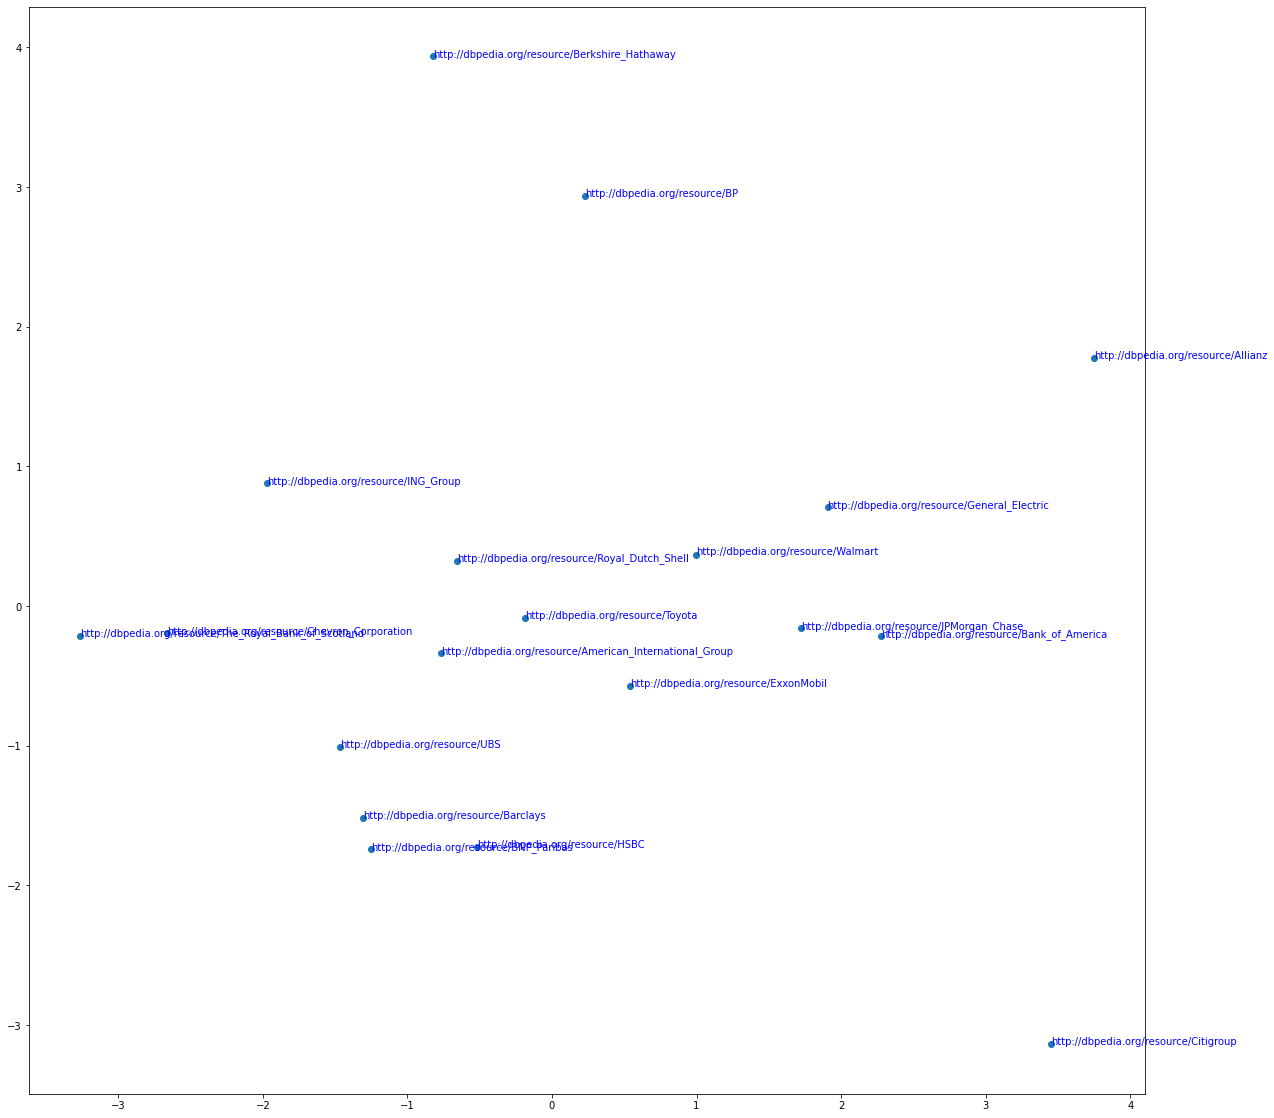

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
plt.scatter(v[:, 0], v[:, 1])
texts = []
for x, y, country in zip(v[:, 0], v[:, 1], e):
    plt.text(x,y,country, c='b')

#adjust_text(texts, lim=15, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
plt.show()